<div style="text-align: center;">
  <h1>TA136 - Taller de Procesamiento de Señales</h1>
  <h2>Trabajo Práctico 8: EM + K-Means</h2>
</div>

---
---

<div style="text-align: center;">
  <h3> Introducción
</div>

&ensp; En el presente trabajo práctico se aborda el problema de clasificación de señales acústicas correspondientes a diferentes instrumentos musicales, utilizando algoritmos de aprendizaje no supervisado. La base de datos utilizada está compuesta por grabaciones de $5$ instrumentos distintos, y el desarrollo consiste en tres etapas: exploración, entrenamiento y testeo.

&ensp; En primer lugar, se cargan las señales mediante la librería `librosa`, reservando un archivo de cada una de las clases para realizar el testeo. Posteriormente, se acondicionan las señales en el dominio de las frecuencias, obteniendo espectrogramas mediante la transformada de Fourier de corto plazo (STFT), con una configuración recomendada por la cátedra, a fin de capturar las características relevantes del audio de cada instrumento.

&ensp; Luego, en la etapa de entrenamiento, se hace un desarrollo propio del algoritmo *K-Means*, para entrenar un modelo por cada una de las clases presentes. A partir de los centroides y las clasificaciones obtenidas, se inicializa y se entrena un modelo de mezcla de $6$ gaussianas por instrumento, mediante funciones de la librería `sklearn`. Finalmente, en la parte de testeo, se evalúa la log-verosimilitud de las señales frente a cada modelo, se calculan probabilidades a posteriori utilizando la regla de Bayes, y se analiza la evolución temporal de estas probabilidades para la señal de testeo de la guitarra.

---
---

<div style="text-align: center;">
  <h3> Desarrollo
</div>

**En el archivo $\texttt{instrumentos.zip}$ encontrará audios de diferentes instrumentos musicales. Se desea clasificar entre las $5$ clases de instrumentos presentes en la base de datos.**

---

#### (A). *Exploración de datos:*

**- Utilizando $\texttt{load}$ (`librosa`), construir $5$ conjuntos de datos de entrenamiento y $5$ de testeo (uno por instrumento). Reservar el último archivo de cada instrumento para el conjunto de testeo, y utilizar el resto para entrenamiento.**

&ensp; En un principio, se carga el conjunto de datos a partir de los audios dispuestos en el archivo $\texttt{instrumentos.zip}$. Para extraer los datos de la *URL* correspondiente, se utilizan los comandos de $\texttt{wget}$ y $\texttt{unzip}$, seguidos de la función recomendada por la cátedra. Esta última, lee los datos de cada uno de los instrumentos en forma secuencial y los almacena en una matriz de $n_{\text{instrumentos}} \times n_{\text{audios}}$, que será de $5 \times 5$.

&ensp; De esta manera, se obtiene una matriz de listas, ya que, cada audio tiene una duración distinta y no se pueden almacenar en una matriz estática. Esto tiene la forma que se ve a continuación, donde cada subindice corresponde a las posiciones dentro de la matriz.

\begin{align*}
\text{samples} =
  \begin{bmatrix}
    \text{clarinet}_{0, ~0} & \dots & \text{clarinet}_{0, ~4} \\
    \text{guitar}_{1, ~1} & \dots & \text{guitar}_{1, ~4} \\
    \text{saxophone}_{2, ~1} & \dots & \text{saxophone}_{2, ~4} \\
    \text{trumpet}_{3, ~1} & \dots & \text{trumpet}_{3, ~4} \\
    \text{violin}_{4, ~1} & \dots & \text{violin}_{4, ~4} \\
  \end{bmatrix}
\end{align*}

&ensp; De aquí, se almacenan los últimos archivos para el conjunto de testeo y con los otros se tiene el conjunto de entrenamiento, tal que:

\begin{align*}
X_\text{train} =
  \begin{bmatrix}
    \text{clarinet}_{0, ~0} & \dots & \text{clarinet}_{0, ~3} \\
    \text{guitar}_{1, ~1} & \dots & \text{guitar}_{1, ~3} \\
    \text{saxophone}_{2, ~1} & \dots & \text{saxophone}_{2, ~3} \\
    \text{trumpet}_{3, ~1} & \dots & \text{trumpet}_{3, ~3} \\
    \text{violin}_{4, ~1} & \dots & \text{violin}_{4, ~3} \\
  \end{bmatrix}
  \in \mathbb{R^{5 \times 4}}, ~
  X_\text{test} =
  \begin{bmatrix}
    \text{clarinet}_{0, ~4} \\
    \text{guitar}_{1, ~4} \\
    \text{saxophone}_{2, ~4} \\
    \text{trumpet}_{3, ~4}  \\
    \text{violin}_{4, ~4}  \\
  \end{bmatrix} \in \mathbb{R^{5 \times 1}}
\end{align*}

&ensp; Cabe destacar nuevamente que cada uno de los elementos dentro de las matrices son listas con un tamaño correspondiente al tiempo de duración y la frecuencia de muestreo, que es de $fs = 44.1 ~ kHz$.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import librosa as lib
import glob
import pandas as pd

In [ ]:
!wget https://github.com/mvera1412/TA136-TB056-TB057-8625/raw/4fc82282f9b241704acfa138a536923efd99a168/data/instrumentos.zip -O instrumentos.zip
!unzip -q instrumentos.zip -d instrumentos

--2025-05-31 22:49:31--  https://github.com/mvera1412/TA136-TB056-TB057-8625/raw/4fc82282f9b241704acfa138a536923efd99a168/data/instrumentos.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mvera1412/TA136-TB056-TB057-8625/4fc82282f9b241704acfa138a536923efd99a168/data/instrumentos.zip [following]
--2025-05-31 22:49:31--  https://raw.githubusercontent.com/mvera1412/TA136-TB056-TB057-8625/4fc82282f9b241704acfa138a536923efd99a168/data/instrumentos.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 606906 (593K) [application/zip]
Saving to: ‘instrumentos.zip’

instrumentos.zip    100%[===========

In [ ]:
instruments = ['clarinet', 'guitar', 'saxophone', 'trumpet', 'violin']
n_instruments = len(instruments)
n_audios = 5

path = 'instrumentos/'

fs = 44100
samples = np.zeros((n_instruments, n_audios), dtype=np.ndarray) # Se muestrea a 44100 Hz

for i in range(n_instruments):
    ruta = sorted(glob.glob(path + instruments[i] + '*.mp3'))
    for j in range(n_audios):
        samples[i, j], _ = lib.load(ruta[j], sr=fs)

In [ ]:
X_train = samples[:, :-1]
X_test = samples[:, -1]

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (5, 4)
X_test shape: (5,)


**- Graficar la señal temporal de la señal de testeo de la guitarra en función del tiempo (en segundos).**

&ensp; A fin de analizar que la forma de las muestras correspondientes al conjunto de testeo, se grafica la señal de la guitarra en función del tiempo.

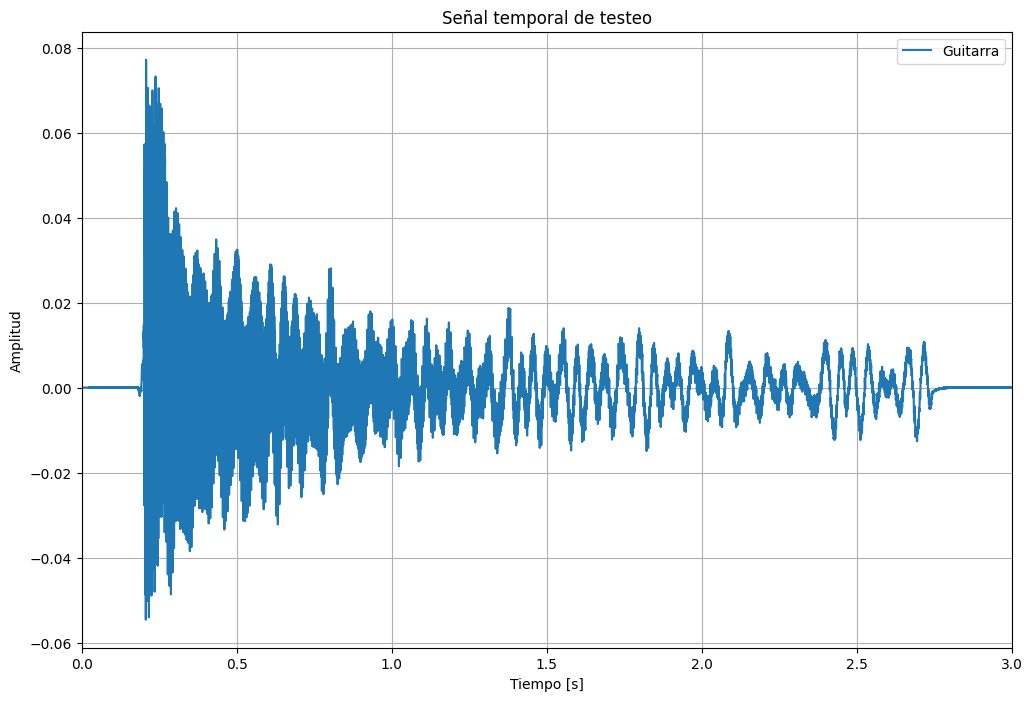

In [ ]:
t = np.arange(X_test[1].shape[0]) / fs

plt.figure(figsize=(12, 8))
plt.plot(t, X_test[1], label='Guitarra')
plt.title('Señal temporal de testeo')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid()
plt.xlim(0, 3)
plt.legend()
plt.show()

**- Reproducir el audio de testeo de la guitarra utilizando $\texttt{Audio}$ (`IPython`).**

  &ensp; También, a partir de la función recomendada por la cátedra, se reproduce el audio de la misma señal a fin de verificar que sea coincidente con el último de los pertenecientes a la guitarra.

In [ ]:
from IPython.display import Audio

Audio(X_test[1], rate=fs)

**- Utilizando $\texttt{ShortTimeFFT}$ (`scipy.signal`). Extraer un espectrograma de cada señal.**

&ensp; En función de $\texttt{ShortTimeFFT}$, se utiliza una FFT de $64$ puntos con un solapamiento del $50 ~ \%$, dado por el `hop`. Además, se descarta la parte simétrica del espectro, pasando el parámetro `onesided` y se utiliza una  ventana de hamming de la misma cantidad de puntos de la FFT, realizada a partir de $\texttt{hamming}$ de la librería `Numpy`.

&ensp; Las FFTs se almacenan de la misma manera que las muestras. En este caso, en vez de listas, cada item de la matriz contiene otra matriz correspondiente a la FFT de la señal, tal que:

\begin{align*}
X_{FFT_\text{train}} =
  \begin{bmatrix}
    FFT_{\text{clarinet}_{0, ~0}} & \dots & FFT_{\text{clarinet}_{0, ~3}} \\
    FFT_{\text{guitar}_{1, ~1}} & \dots & FFT_{\text{guitar}_{1, ~3}} \\
    FFT_{\text{saxophone}_{2, ~1}} & \dots & FFT_{\text{saxophone}_{2, ~3}} \\
    FFT_{\text{trumpet}_{3, ~1}} & \dots & FFT_{\text{trumpet}_{3, ~3}} \\
    FFT_{\text{violin}_{4, ~1}} & \dots & FFT_{\text{violin}_{4, ~3}} \\
  \end{bmatrix}
  \in \mathbb{R^{5 \times 4}}, ~
  X_\text{test} =
  \begin{bmatrix}
    FFT_{\text{clarinet}_{0, ~4}} \\
    FFT_{\text{guitar}_{1, ~4}} \\
    FFT_{\text{saxophone}_{2, ~4}} \\
    FFT_{\text{trumpet}_{3, ~4}}  \\
    FFT_{\text{violin}_{4, ~4}}  \\
  \end{bmatrix} \in \mathbb{R^{5 \times 1}}
\end{align*}

&ensp; Donde cada elemento dentro de la matriz es de dimensión $\mathbb{R}^{  n_{\text{ventanas} \times 33}}$ puesto que son transformadas de $64$ puntos con un `hop` del $50 \%$. Igualmente, se debe tener en cuenta que se tiene esta dimensión, dado que, se transpone cada matriz FFT para facilitar la forma en la que se concatenan los datos, a fin de normalizar y entrenar los modelos posteriores.

In [ ]:
from scipy.signal import ShortTimeFFT

n_fft = 64

window = np.hamming(n_fft)
FFT = ShortTimeFFT(mfft=n_fft, win=window, fs=fs, hop=n_fft // 2, fft_mode='onesided')

X_train_fft = np.zeros((n_instruments, n_audios - 1), dtype=np.ndarray)
X_test_fft = np.zeros((n_instruments), dtype=np.ndarray)

for i in range(n_instruments):
    X_test_fft[i] = (np.abs(FFT.stft(X_test[i])) ** 2).T
    print('X_test_fft[{}] shape:'.format(i), X_test_fft[i].shape)
    for j in range(n_audios - 1):
        X_train_fft[i, j] = (np.abs(FFT.stft(X_train[i, j])) ** 2).T
        print('X_train_fft[{}][{}] shape:'.format(i, j), X_train_fft[i, j].shape)


X_test_fft[0] shape: (3025, 33)
X_train_fft[0][0] shape: (3169, 33)
X_train_fft[0][1] shape: (3097, 33)
X_train_fft[0][2] shape: (3097, 33)
X_train_fft[0][3] shape: (2125, 33)
X_test_fft[1] shape: (4825, 33)
X_train_fft[1][0] shape: (9937, 33)
X_train_fft[1][1] shape: (5437, 33)
X_train_fft[1][2] shape: (7129, 33)
X_train_fft[1][3] shape: (6409, 33)
X_test_fft[2] shape: (1549, 33)
X_train_fft[2][0] shape: (1765, 33)
X_train_fft[2][1] shape: (1729, 33)
X_train_fft[2][2] shape: (1801, 33)
X_train_fft[2][3] shape: (1873, 33)
X_test_fft[3] shape: (3385, 33)
X_train_fft[3][0] shape: (3529, 33)
X_train_fft[3][1] shape: (3457, 33)
X_train_fft[3][2] shape: (3457, 33)
X_train_fft[3][3] shape: (3169, 33)
X_test_fft[4] shape: (2305, 33)
X_train_fft[4][0] shape: (1585, 33)
X_train_fft[4][1] shape: (2341, 33)
X_train_fft[4][2] shape: (2665, 33)
X_train_fft[4][3] shape: (2449, 33)


&ensp; Ahora que se tienen almacenadas las FFTs, se procede a graficarlas. A fin de realizar esto, se desarrolla la función $\texttt{plot\_spectrogram}$ y se plotean los espectrogramas de entrenamiento y los de testeo.

In [ ]:
def plot_spectrogram(time, freq, fft_matrix, titulo):
  plt.pcolormesh(time, freq, 20*np.log(fft_matrix), shading='gouraud')
  plt.title(titulo)
  plt.xlabel('Tiempo [s]')
  plt.ylabel('Frecuencia [Hz]')
  plt.yticks([0, 1000, 2000, 3000, 4000, 5000], ['0', '1000', '2000', '3000', '4000', '5000'])
  plt.ylim(0, 5000)

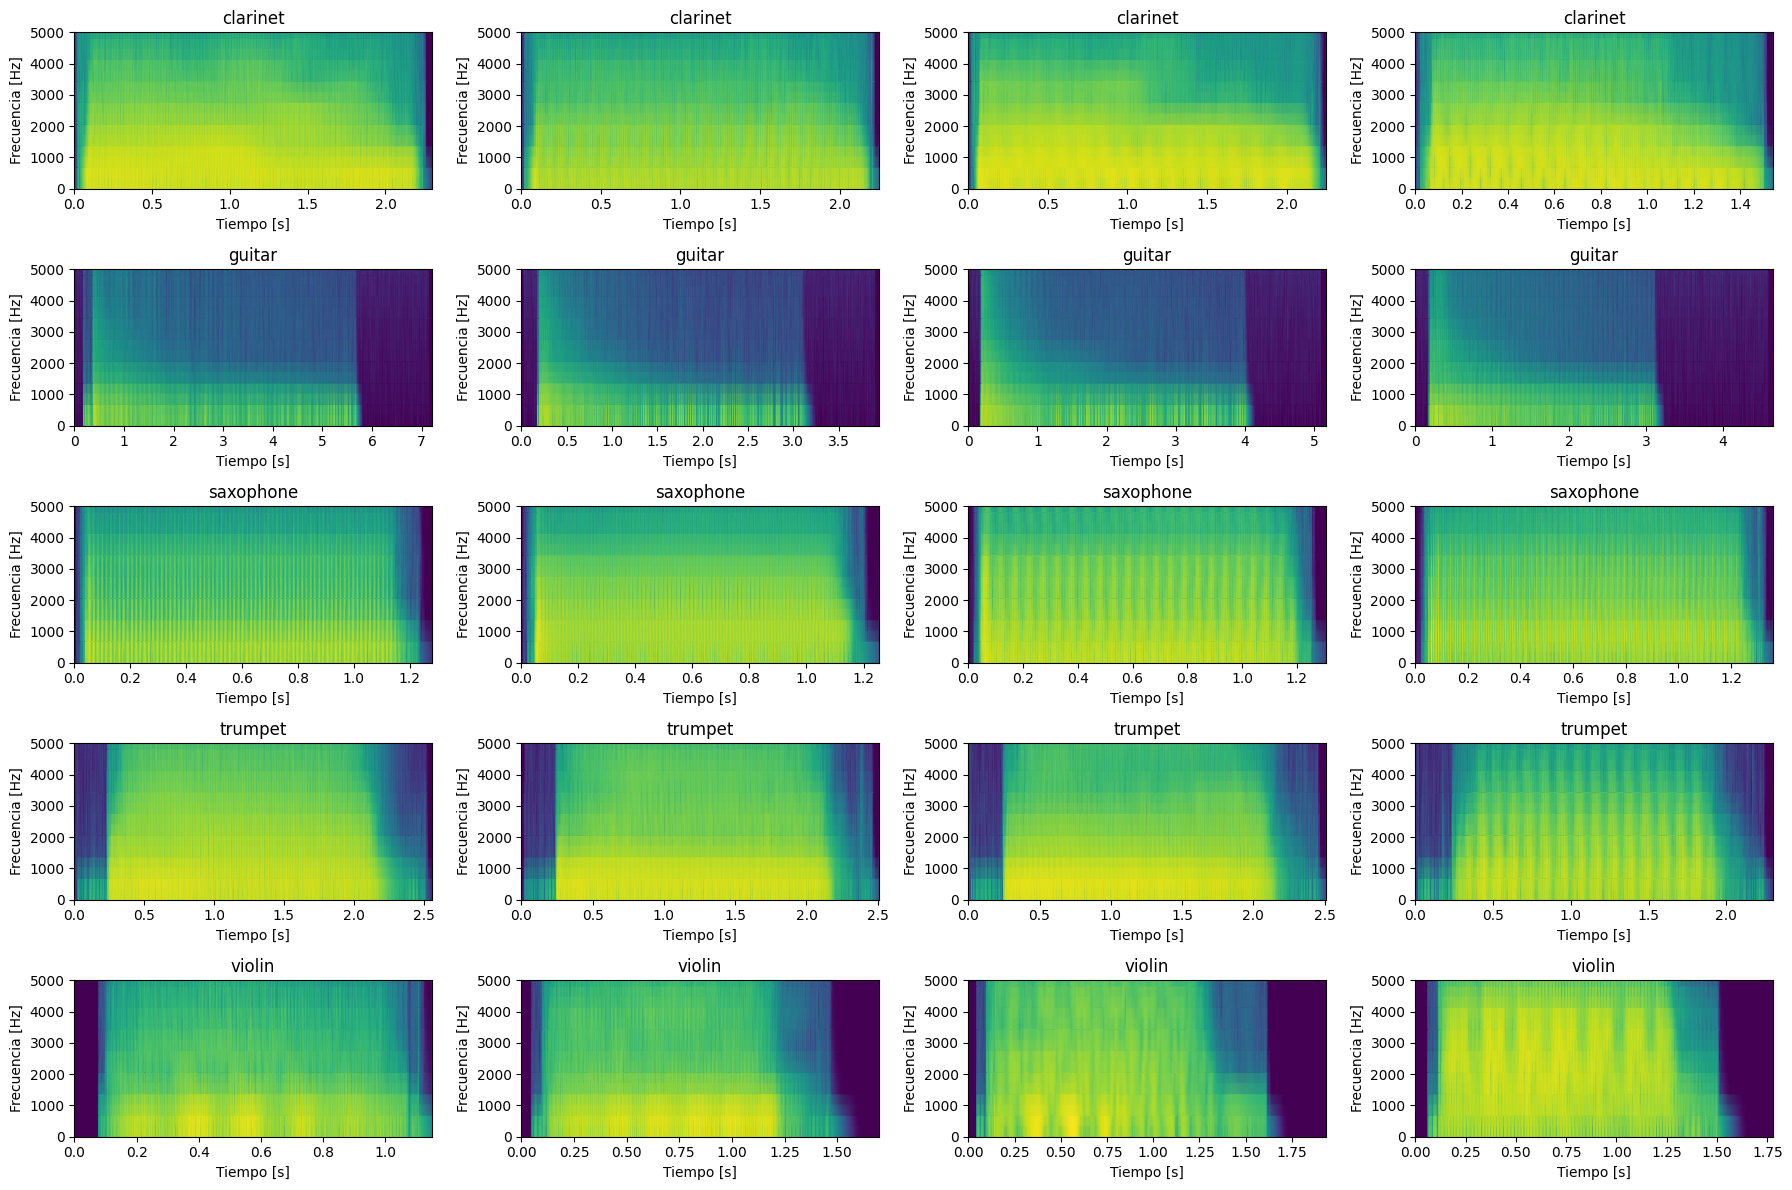

In [ ]:
plt.figure(figsize=(18, 12))
for i in range(n_instruments):
  for j in range(n_audios - 1):
    plt.subplot(n_instruments, n_audios - 1, i * (n_audios - 1) + j + 1)
    plot_spectrogram(FFT.t(len(X_train[i, j])), FFT.f, X_train_fft[i, j].T, instruments[i])

plt.tight_layout()
plt.show()

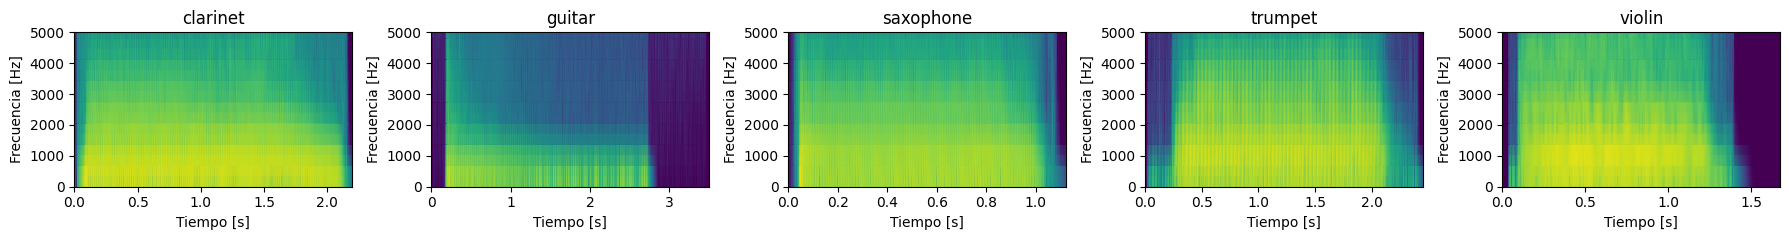

In [ ]:
plt.figure(figsize=(18, 2.5))
for i in range(n_instruments):
  plt.subplot(1, n_instruments, i + 1)
  plot_spectrogram(FFT.t(len(X_test[i])), FFT.f, X_test_fft[i].T, instruments[i])

plt.tight_layout()
plt.show()

&ensp; Una vez obtenidas las matrices correspondientes a las FFTs, se acumulan las $4$ FFTs de entrenamiento correspondientes a cada uno de los instrumentos. Así, se tienen en $\texttt{X\_train\_fft\_concat}$ todas las FFTs acumuladas y divididas según cada instrumento.

&ensp; Luego, se concatenan todos los elementos tanto de entrenamiento como de testeo, independientemente de los instrumentos, para así normalizarlos con el $\texttt{StandardScaler}$, utilizado en trabajos anteriores. También, se guardan los índices que dividen las muestras de cada instrumento, a fin de poder separar con $\texttt{split}$ según el instrumento luego de realizar la normalización.

In [ ]:
X_train_fft_concat = np.zeros(n_instruments, dtype=np.ndarray)
for i in range(n_instruments):
    X_train_fft_concat[i] = np.concatenate([X_train_fft[i, j] for j in range(n_audios - 1)], axis=0)

X_train_concat = np.concatenate(X_train_fft_concat, axis = 0)
X_test_concat = np.concatenate(X_test_fft, axis = 0)

cant_samples_train = np.array([X_train_fft_concat[i].shape[0] for i in range(n_instruments)])
indices_train = np.cumsum(cant_samples_train)
indices_test = np.cumsum([X_test_fft[i].shape[0] for i in range(n_instruments)])

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train_concat)

X_train_norm = scaler.transform(X_train_concat)
X_test_norm = scaler.transform(X_test_concat)

X_train_norm = np.split(X_train_norm, indices_train, axis = 0)[:-1]
X_test_norm = np.split(X_test_norm, indices_test, axis = 0)[:-1]

---

#### (B). *Entrenamiento:*

**- Entrenar $5$ algoritmos K-Means (uno por cada instrumento). El código debe estar estructurado de la siguiente manera:**
```python
    class Kmeans:
        # Inicializar atributos y declarar hiperparámetros
        def __init__(self, ...
        
        # Etapa de entrenamiento
        def fit(self, X):
        
        # Etapa de testeo
        def predict(self, X):
```

&ensp; Con el objetivo de entrenar un *K-Means* por instrumento, se implementó la clase llamada $\texttt{Kmeans}$, que consta de los siguientes métodos.

- `__init__:` Inicializa la clase y declara los atributos necesarios para almacenar los parámetros del modelo, tales como la cantidad `k` de *clusters*, los centroides de cada clase y la predicción de la clase de cada muestra.

- `fit:` Ajusta el modelo a los datos de entrenamiento. Para ello, realiza los siguientes pasos:
    1. Se eligen $k$ centroides de forma aleatoria.
    2. Cada muestra se asigna al *cluster* cuyo centroide esté más cercano, utilizando la norma:

      $$y = \min_j \left\(\sqrt{\sum_{i = 0}^n |x_i - \mu_j|^2} \right)$$
      
    3. Se calcula la media de los datos pertenecientes a cada *cluster* y se los compara con los centroides obtenidos.
    4. Si la norma de la diferencia entre los centroides anteriores y los nuevos es menor que un umbral (en este caso $1 \times 10^{-15}$), el algoritmo converge. En caso contrario, se repite desde el paso $2$.
  
- `predict:` Realiza predicciones para nuevos datos una vez que el modelo ha sido entrenado. Utiliza los centroides obtenidos en la fase de entrenamiento para estimar a qué *cluster* pertenece cada muestra de entrada. Para ello, realiza lo mismo que en se hace en el punto $2$ del método anterior, es decir, calcula la distancia euclídea entre las muestras y los centroides, y asigna la clase correspondiente al centroide más cercano.

In [ ]:
class KMeans:
    # Inicializar atributos y declarar hiperparámetros
    def __init__(self, k):
        if k < 1:
            raise ValueError("El número de clusters debe ser mayor que 0")

        self.k = k
        self.centroids = None
        self.y = None

    # Etapa de entrenamiento
    def fit(self, X):
        self.centroids = X[np.random.choice(X.shape[0], self.k, replace=False)]

        seguir_iterando = True
        iteraciones = 0
        while(seguir_iterando and iteraciones < 10000):
            self.y = np.array([np.argmin(np.linalg.norm(x - self.centroids, axis=1)) for x in X])

            mean_classes = np.array([np.mean(X[self.y == k], axis=0) for k in range(self.k)])
            if np.linalg.norm(mean_classes - self.centroids) < 1e-6:
                seguir_iterando = False

            self.centroids = mean_classes
            iteraciones += 1

    # Etapa de testeo
    def predict(self, X):
        return np.array([np.argmin(np.linalg.norm(x - self.centroids, axis=1)) for x in X])

&ensp; Una vez desarrollada la clase, se inicializa y se entrena un *K-Means* para cada instrumento y se guarda cada clase en la lista $\texttt{KM\_instruments}$.

In [ ]:
KM_instruments = []
k_value = 6
for i in range(n_instruments):
    KM_instruments.append(KMeans(k=k_value))
    KM_instruments[i].fit(X_train_norm[i])

**- Utilizando $\texttt{GaussianMixture}$ (`sklearn`), entrenar $5$ mezclas de $6$ gaussianas diagonales cada una (una por cada instrumento) utilizando el algoritmo EM. Inicializar dicho algoritmo utilizando el K-Means desarrollado en el item anterior.**

&ensp; En base a los modelos entranados anteriormente, se tienen los valores de los centroides, los clusters a los que pertenece cada muestra y la cantidad de *clusters* utilizados en el entrenamiento del *K-Mean* para cada instrumento. De esta manera, se procede a entrenar una mezcla de gaussianas por cada instrumento.

&ensp;  Para ello, se utiliza la función provista por la cátedra, la cual requiere como entrada la cantidad de componentes a utilizar en la mezcla, junto con los pesos, las medias y las varianzas. A continuación, se detalla cómo se obtiene cada uno de estos parámetros a partir del entrenamiento del algoritmo *K-Means*.

- **Cantidad de componentes:** corresponde a la cantidad de *clusters* utilizados en el *K-Means*, define la cantidad de gaussianas que componen la mezcla.

- **Pesos:** como se tiene un array con el *cluster* al que pertenece cada muestra según su orden, se obtiene la proporción de muestras asignadas a cada *cluster*. Este valor determina la importancia de cada una de las gaussianas que componen la mezcla en el *GMM*.

- **Medias:** se toman los centroides obtenidos mediante el *fit* del *K-Means*, son los puntos en los cuales se van a centrar las elipses de cada gaussiana, es decir, su centro de masa.

- **Varianzas:** para cada *cluster*, se recopilan las muestras que le fueron asignadas con el $\texttt{self.y}$ del entrenamiento de *K-Means* y se calcula su varianza. Este parámetro define la dispersión y orientación de cada gaussiana en la mezcla.

In [ ]:
from sklearn.mixture import GaussianMixture

GM_instruments = []

for i in range(n_instruments):
    k_i = KM_instruments[i].k
    pesos = np.array([np.mean(KM_instruments[i].y == k) for k in range(k_i)])
    cov = np.array([np.var(X_train_norm[i][KM_instruments[i].y == k], axis=0) for k in range(k_i)])
    GM = GaussianMixture(n_components=k_i, covariance_type='diag', means_init=KM_instruments[i].centroids, weights_init=pesos, precisions_init=1./cov, tol=1e-6, max_iter=10000)
    GM_instruments.append(GM)
    GM_instruments[i].fit(X_train_norm[i])


---

#### (C). *Testeo:*

**- Para todas las combinaciones se desea evaluar que tan verosímil es que las muestras de la clase *i*-ésima correspondan al modelo *j*-ésimo. Indicar las *log-verosimilitud* correspondientes en un cuadro de doble entrada del algoritmo EM.**

&ensp; A fin de realizar esta evaluación, se utiliza el método $\texttt{score\_samples}$, que calcula la log-verosimilitud de cada muestra dado un modelo previamente entrenado. Matemáticamente, teniendo en cuenta esto y considerando la independencia entre las muestras, se puede calcular la probabilidad de que el conjunto de datos del instrumento haya sido generado por el modelo entrenado para el instrumento.

\begin{align*}
  P(D_i ~ | ~ \text{modelo}_j) &= \prod_{t=1}^T p(x_t ~ | ~ \text{modelo}_j) \\
  \log P(D_i ~ | ~ \text{modelo}_j) &= \sum_{t=1}^T \underbrace{\log p(x_t ~ | ~ \text{modelo}_j)}_{\texttt{score\_samples}}
\end{align*}

&ensp; De esta manera, se obtienen los resultados que se visualizan a continuación.

In [ ]:
log_verosimilitudes = np.zeros((n_instruments, n_instruments))

for i in range(n_instruments):
    for j in range(n_instruments):
        log_verosimilitudes[i, j] = np.sum(GM_instruments[j].score_samples(X_test_norm[i]))

test_instruments = ['test_clarinet', 'test_guitar', 'test_saxophone', 'test_trumpet', 'test_violin']
display(pd.DataFrame(log_verosimilitudes, index=test_instruments, columns=instruments).round(2))

,clarinet,guitar,saxophone,trumpet,violin
test_clarinet,159663.08,-332326.66,114787.71,105995.40,61650.31
test_guitar,427761.86,728326.32,472296.11,393265.40,529615.56
test_saxophone,-45822.89,-1165151.67,43372.77,13253.91,-9036.34
test_trumpet,34564.86,-25046761.09,150891.27,159653.94,77871.22
test_violin,-184675.24,-3338076.52,78288.17,77809.83,55889.48


**- Cada algoritmo *j*−ésimo define una distribución $p(x|j)$. Asumiendo una probabilidad de cada clase $P(j)$ proporcional a la cantidad de muestras de entrenamiento de cada instrumento, calcular las probabilidades a posteriori a partir de la regla de bayes. Es decir, indicar en un cuadro de doble entrada la probabilidad de la clase *j*-ésima para las muestras correspondientes al instrumento *i*-ésimo $P(j | D_i)$.**

&ensp; A partir de lo obtenido anteriormente, es posible estimar la probabilidad de observar un conjunto de muestras dado un determinado modelo. En este caso, además, se calcula la probabilidad a priori de cada clase, tal que:

$$ P(\text{modelo}_j) = \frac{\# \text{muestras}_j}{\# \text{muestras totales}}$$

En base a esto y utilizando el teorema de bayes considerando la probabilidad total, se tiene que:

\begin{align*}
  P(\text{modelo}_j ~ | ~ D_i) &= \frac{P(D_i ~ | ~ \text{modelo}_j) \cdot P(\text{modelo}_j)}{\sum_{j = 0}^4 P(D_i ~ | ~ \text{modelo}_j) \cdot P(\text{modelo}_j)} \\
  e^{\log P(\text{modelo}_j ~ | ~ D_i)} &=  \frac{e^{\log P(D_i ~ | ~ \text{modelo}_j) + \log P(\text{modelo}_j)}}{\sum_{j = 0}^4 e^{\log P(D_i ~ | ~ \text{modelo}_j) + \log P(\text{modelo}_j)}}
\end{align*}

&ensp; Donde esta última expresión es exactamente lo que realiza la función $\texttt{softmax}$, propuesta por la cátedra. Dando así la probabilidad a posteriori de que se pertenezca a un modelo dado un conjunto de datos.

In [ ]:
from scipy.special import softmax

log_proba_clase = np.log(cant_samples_train / X_train_concat.shape[0])
posteriori = softmax(log_verosimilitudes + log_proba_clase, axis=1)

display(pd.DataFrame(posteriori, index=test_instruments, columns=instruments).round(3))

,clarinet,guitar,saxophone,trumpet,violin
test_clarinet,1.0,0.0,0.0,0.0,0.0
test_guitar,0.0,1.0,0.0,0.0,0.0
test_saxophone,0.0,0.0,1.0,0.0,0.0
test_trumpet,0.0,0.0,0.0,1.0,0.0
test_violin,0.0,0.0,1.0,0.0,0.0


&ensp; Se ve como el modelo predice correctamente en los casos de clarinete, guitarra, saxofón y trompeta. Aunque, en el caso del violin, se observa que el modelo está clasificando de una forma incorrecta, esto se debe principalmente a que en la tabla anterior, los valores mayores de la $\log P(D_i ~ | ~ \text{modelo}_j)$ son los correspondientes al saxofón y a la trompeta, cuando $D_i$ es el conjunto de testeo del violín.

**- Sea $x(t)$ la señal correspondiente al audio de testeo de la guitarra. Graficar $\log P(j|x(t))$ en función del tiempo, para cada uno de los $5$ instrumentos (indexados por *j*).**

&ensp; A fin de desarrollar lo solicitado, se calcula la $\log p(x_t ~ | ~ \text{modelo}_j)$ para cada muestra. A diferencia del inciso anterior, donde se consideraba la verosimilitud conjunta de todas las muestras, aquí se analiza cada muestra por separado, sin realizar una sumatoria.

&ensp; Aplicando el teorema de Bayes junto con las probabilidades a priori de cada clase y las propiedades del logaritmo, se obtiene la expresión de la probabilidad a posteriori en cada instante de tiempo:

\begin{align*}
  P(\text{modelo}_j ~ | ~ x(t)) &= \frac{P(x(t) ~ | ~ \text{modelo}_j) \cdot P(\text{modelo}_j)}{\sum_{j = 0}^4 P(x(t) ~ | ~ \text{modelo}_j) \cdot P(\text{modelo}_j)} \\
  e^{\log P(\text{modelo}_j ~ | ~ x(t))} &=  \frac{e^{\log P(x(t) ~ | ~ \text{modelo}_j) + \log P(\text{modelo}_j)}}{\sum_{j = 0}^4 e^{\log P(x(t) ~ | ~ \text{modelo}_j) + \log P(\text{modelo}_j)}}
\end{align*}

&ensp; Al igual que anteriormente, este resultado corresponde a a la operación realizada por la función $\texttt{softmax}$.

&ensp; Así, se realiza la función $\texttt{plot\_proba}$ con el fin de graficar el logaritmo de la probabilidad en función del tiempo para el audio de testeo de la guitarra.

In [ ]:
def plot_proba(time, log_proba, titulo):
  plt.plot(time, log_proba, label=instruments[j] + ' model')
  plt.xlabel('Tiempo [s]')
  plt.ylabel('$\log \mathbb{P}(j ~ | ~ x(t) )$')
  plt.legend(loc='lower right')
  plt.grid()
  plt.suptitle(titulo, fontsize=14)

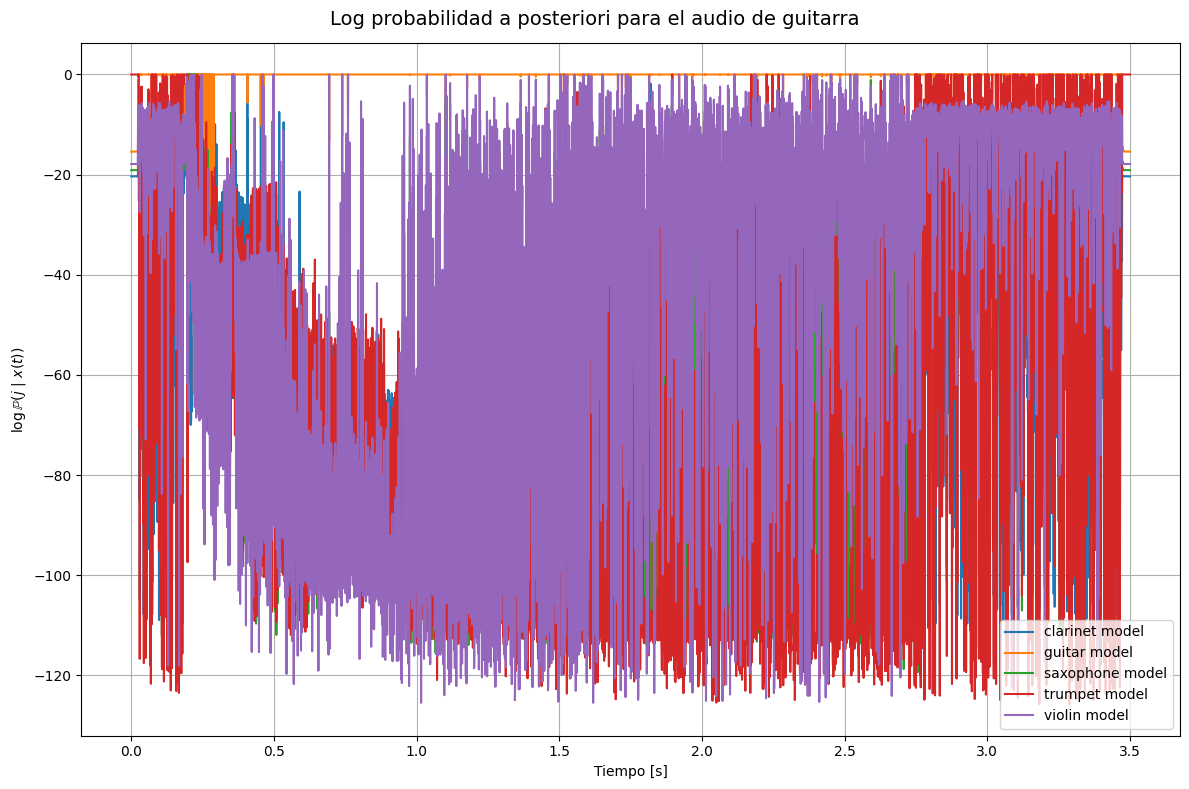

In [ ]:
log_total_guitar = np.stack([GM_instruments[j].score_samples(X_test_norm[1]) + log_proba_clase[j] for j in range(n_instruments)])
posteriori_guitar = softmax(log_total_guitar, axis=0)
t = np.linspace(0, X_test[1].shape[0] / fs, X_test_fft[1].shape[0])

plt.figure(figsize=(12, 8))
for j in range(n_instruments):
  plot_proba(t, np.log(posteriori_guitar[j, :]), 'Log probabilidad a posteriori para el audio de guitarra')

plt.tight_layout()
plt.show()

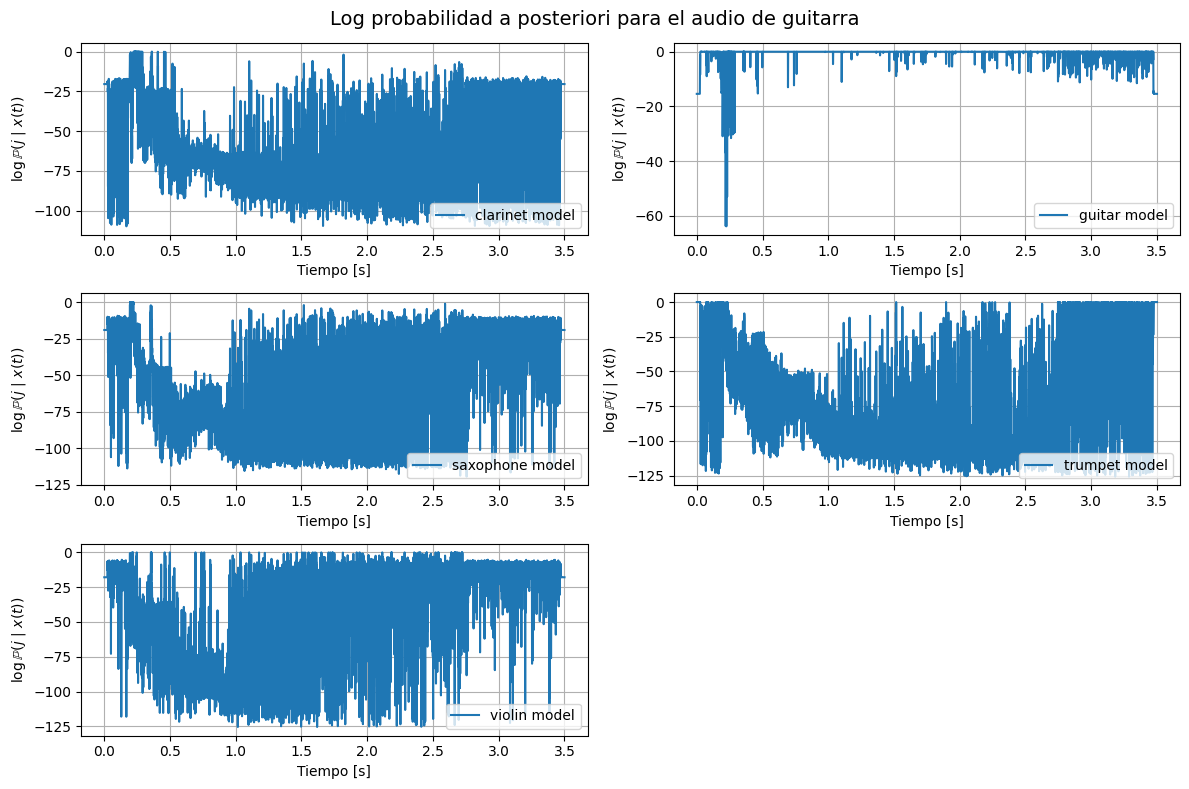

In [ ]:
plt.figure(figsize=(12, 8))
for j in range(n_instruments):
    plt.subplot(3, 2, j + 1)
    plot_proba(t, np.log(posteriori_guitar[j, :]), 'Log probabilidad a posteriori para el audio de guitarra')

plt.tight_layout()
plt.show()

---
---

<div style="text-align: center;">
  <h3> Conclusiones
</div>

&ensp; El presente trabajo permitió aplicar técnicas de aprendizaje no supervisado para la clasificación de señales acústicas, destacando así la utilidad del espectrograma como conjunto de entrenamiento y testeo para audios de distinta duración.

&ensp; La implementación del algoritmo *K-Means* permitió un mayor entendimiento de los conceptos teóricos vistos en las clases del curso. Además, a partir de sus centroides y la clasificación, resulto útil para la posterior inicialización de las mezclas gaussianas utilizadas en el algoritmo EM. Esta combinación mejoró la capacidad de modelado de las señales, reflejándose en log-verosimilitudes y probabilidades a posteriori coherentes con la clase verdadera en todos los casos, salvo el del violin. Esto se cree que sucede puesto a que los audios del violin y otros instrumentos son similares, tanto al escucharlos como al analizar sus espectrogramas.

&ensp; Por otro lado, el análisis probabilístico permitió cuantificar el grado de pertenencia de cada señal a los distintos modelos entrenados, analizando así los resultados y cómo se comporta el algoritmo al ser testeado. Mientras que, la evolución temporal de $\log P(j|x(t))$ permitió observar cómo se comporta la clasificación en función de las muestras/tiempo.

&ensp; En conclusión, este trabajo permitió comprender en profundidad el funcionamiento del algoritmo *K-Means* y su relación con la inicialización de modelos de mezcla de gaussianas entrenados mediante el algoritmo EM. Asimismo, se realizó la aplicación práctica en $\texttt{Python}$.